In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import scipy
import shapely.wkt as pg
import plotly.express as px
import geopandas as gpd
import json
from shapely.geometry import mapping
import plotly.graph_objects as go
import folium
import geopy.distance
from tqdm import tqdm

In [4]:
df_jan = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/yellow_tripdata_2022-01.parquet')

In [5]:
df_jan

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.50,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.00,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.50,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.00,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.50,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2463926,2,2022-01-31 23:36:53,2022-01-31 23:42:51,NaN,1.32,NaN,None,90,170,0,8.00,0.0,0.5,2.39,0.0,0.3,13.69,NaN,NaN
2463927,2,2022-01-31 23:44:22,2022-01-31 23:55:01,NaN,4.19,NaN,None,107,75,0,16.80,0.0,0.5,4.35,0.0,0.3,24.45,NaN,NaN
2463928,2,2022-01-31 23:39:00,2022-01-31 23:50:00,NaN,2.10,NaN,None,113,246,0,11.22,0.0,0.5,2.00,0.0,0.3,16.52,NaN,NaN
2463929,2,2022-01-31 23:36:42,2022-01-31 23:48:45,NaN,2.92,NaN,None,148,164,0,12.40,0.0,0.5,0.00,0.0,0.3,15.70,NaN,NaN


In [6]:
len(df_jan.columns)

19

# Data Information

The yellow taxi dataset is used for the year 2022 only. It includes data like:
1. Vendor ID
2. Pick-up and drop-off dates/times
3. Pick-up and drop-off locations
4. Trip Distances
5. Passenger Count
6. Payment Type and other payment info like fares, tax, tips, tolls, surcharge and total_amount (including airport fee if any)

## Information on Taxis

These are the famous NYC yellow taxis that provide transportation exclusively through street-hails. The number of taxicabs is limited by a finite number of medallions issued by the TLC. You access this mode of transportation by standing in the street and hailing an available taxi with your hand. The pickups are not pre-arranged.

Credits: Quora

Again, in this dataset, the only analysis is done on 2022 Yellow Taxis Only provided solely by TLC

# About Dataset

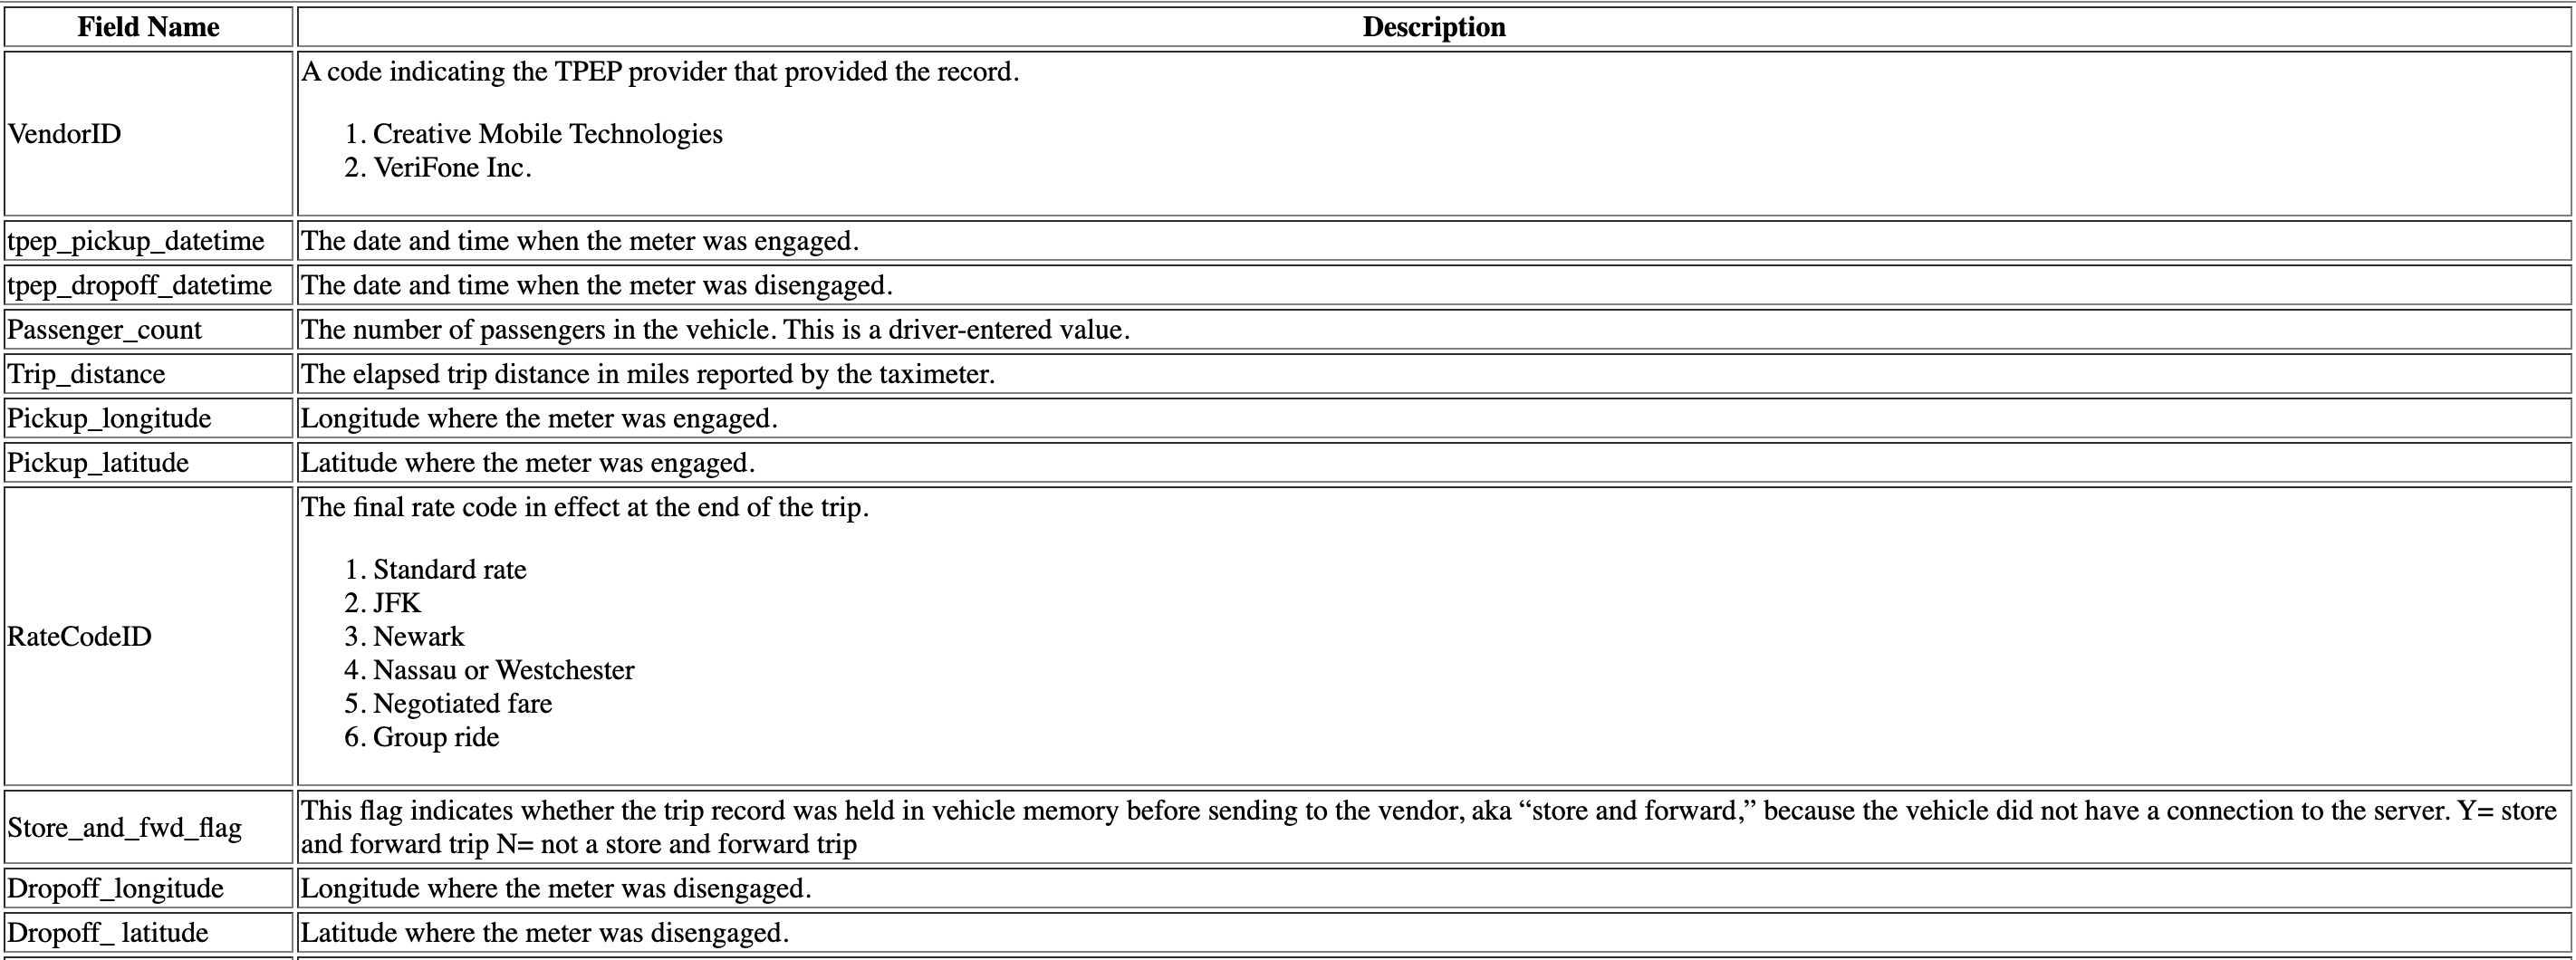

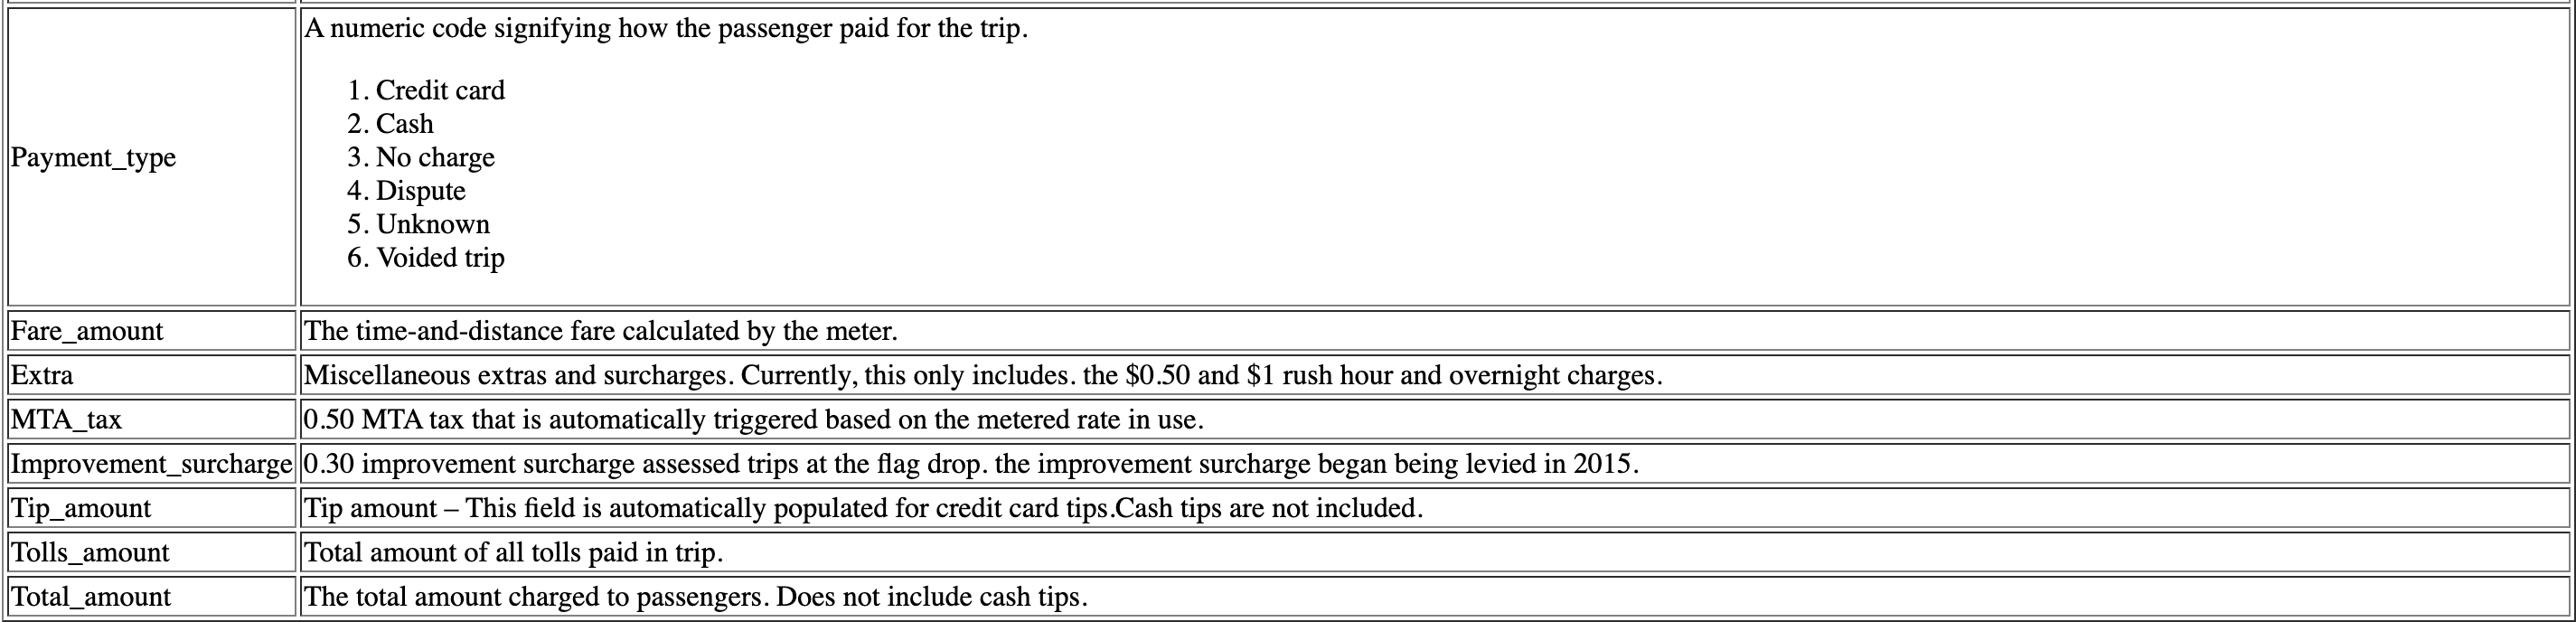


Source: TLC

# What is the problem?

Taxi drivers need to predict how many rides can be present on a particular location so that they can earn more money as well as get more rides. Also, they can optimize for the traffic in different regions i.e, if more taxis are required in the region more taxis can be there when required and faster.

# Business Objectives
- Not much latency requirements - Driver can still wait for few seconds to get results, but it should not be much high. Should not take hours ofcourse
- Prediction should have a value, an percentage error value which can be shown to driver. So he can calculate a value similar to confidence ratio.
- Interpretability is not much important, I dont think driver will care much about the results why they are appearing.

# Machine Learning Problem

Query point will have a latitude, longitude and time.
Output point will be a density (number of rides expected)

We can use training data of 2022, and predict for 2023.





In [7]:
len(df_jan)

2463931

The values of null are really so many, so starting analysis on each of them to improve these.


# Data Cleaning

In [8]:
df_jan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463931 entries, 0 to 2463930
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [9]:
df_jan.isna().any()

VendorID                 False
tpep_pickup_datetime     False
tpep_dropoff_datetime    False
passenger_count           True
trip_distance            False
RatecodeID                True
store_and_fwd_flag        True
PULocationID             False
DOLocationID             False
payment_type             False
fare_amount              False
extra                    False
mta_tax                  False
tip_amount               False
tolls_amount             False
improvement_surcharge    False
total_amount             False
congestion_surcharge      True
airport_fee               True
dtype: bool

### Analysing Passenger Count *

In [10]:
df_jan['passenger_count'].isna().value_counts()

False    2392428
True       71503
Name: passenger_count, dtype: int64

These are so many nulls. As per TLC this data is entered by driver itself, so this might be ignored or may be arbitrarily filled.

### Analysing RateCode ID

In [11]:
df_jan[df_jan['RatecodeID'].isna()]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
2392428,2,2022-01-01 00:50:00,2022-01-01 00:54:00,NaN,1.00,NaN,None,68,246,0,13.20,0.0,0.5,1.75,0.0,0.3,18.25,NaN,NaN
2392429,2,2022-01-01 00:49:24,2022-01-01 01:27:36,NaN,13.31,NaN,None,257,223,0,44.87,0.0,0.5,10.05,0.0,0.3,55.72,NaN,NaN
2392430,2,2022-01-01 00:42:00,2022-01-01 00:56:00,NaN,2.87,NaN,None,143,236,0,13.23,0.0,0.5,3.51,0.0,0.3,20.04,NaN,NaN
2392431,2,2022-01-01 00:40:00,2022-01-01 00:55:00,NaN,3.24,NaN,None,143,262,0,14.19,0.0,0.5,3.72,0.0,0.3,21.21,NaN,NaN
2392432,2,2022-01-01 00:40:00,2022-01-01 00:52:00,NaN,2.19,NaN,None,239,166,0,13.20,0.0,0.5,5.25,0.0,0.3,21.75,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2463926,2,2022-01-31 23:36:53,2022-01-31 23:42:51,NaN,1.32,NaN,None,90,170,0,8.00,0.0,0.5,2.39,0.0,0.3,13.69,NaN,NaN
2463927,2,2022-01-31 23:44:22,2022-01-31 23:55:01,NaN,4.19,NaN,None,107,75,0,16.80,0.0,0.5,4.35,0.0,0.3,24.45,NaN,NaN
2463928,2,2022-01-31 23:39:00,2022-01-31 23:50:00,NaN,2.10,NaN,None,113,246,0,11.22,0.0,0.5,2.00,0.0,0.3,16.52,NaN,NaN
2463929,2,2022-01-31 23:36:42,2022-01-31 23:48:45,NaN,2.92,NaN,None,148,164,0,12.40,0.0,0.5,0.00,0.0,0.3,15.70,NaN,NaN


In [12]:
df_jan['VendorID'].value_counts()

2    1716059
1     742273
6       5563
5         36
Name: VendorID, dtype: int64

In [13]:
df_jan[(df_jan['passenger_count'].isna()) & (df_jan['RatecodeID'].isna()) & (df_jan['store_and_fwd_flag'].isna()) & df_jan['congestion_surcharge'].isna() & df_jan['airport_fee'].isna()]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
2392428,2,2022-01-01 00:50:00,2022-01-01 00:54:00,NaN,1.00,NaN,None,68,246,0,13.20,0.0,0.5,1.75,0.0,0.3,18.25,NaN,NaN
2392429,2,2022-01-01 00:49:24,2022-01-01 01:27:36,NaN,13.31,NaN,None,257,223,0,44.87,0.0,0.5,10.05,0.0,0.3,55.72,NaN,NaN
2392430,2,2022-01-01 00:42:00,2022-01-01 00:56:00,NaN,2.87,NaN,None,143,236,0,13.23,0.0,0.5,3.51,0.0,0.3,20.04,NaN,NaN
2392431,2,2022-01-01 00:40:00,2022-01-01 00:55:00,NaN,3.24,NaN,None,143,262,0,14.19,0.0,0.5,3.72,0.0,0.3,21.21,NaN,NaN
2392432,2,2022-01-01 00:40:00,2022-01-01 00:52:00,NaN,2.19,NaN,None,239,166,0,13.20,0.0,0.5,5.25,0.0,0.3,21.75,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2463926,2,2022-01-31 23:36:53,2022-01-31 23:42:51,NaN,1.32,NaN,None,90,170,0,8.00,0.0,0.5,2.39,0.0,0.3,13.69,NaN,NaN
2463927,2,2022-01-31 23:44:22,2022-01-31 23:55:01,NaN,4.19,NaN,None,107,75,0,16.80,0.0,0.5,4.35,0.0,0.3,24.45,NaN,NaN
2463928,2,2022-01-31 23:39:00,2022-01-31 23:50:00,NaN,2.10,NaN,None,113,246,0,11.22,0.0,0.5,2.00,0.0,0.3,16.52,NaN,NaN
2463929,2,2022-01-31 23:36:42,2022-01-31 23:48:45,NaN,2.92,NaN,None,148,164,0,12.40,0.0,0.5,0.00,0.0,0.3,15.70,NaN,NaN


On the above analysis, we can observe that passenger count is NaN when Ratecode ID is NaN.

But the question is why?

Passenger Count is NaN, maybe if driver forgets it. Also the RateCode ID is NA, this may be correlated ki driver have submitted these forms abruptly.

On further analyis found that all those 4 features are null for particular set of rows only and that too for some last rows of the dataset.

In [14]:
nulls = df_jan[(df_jan['passenger_count'].isna()) & (df_jan['RatecodeID'].isna()) & (df_jan['store_and_fwd_flag'].isna()) & df_jan['congestion_surcharge'].isna() & df_jan['airport_fee'].isna()]

In [15]:
null_index = nulls.index

for i in range(2392428, 2463931):
  if i not in null_index:
    print("Not valid")
    break

Proves that this value is just not existing for some last values of the dataset i.e, 71,503. Will try to fill a value for them, as they are a lot and there might be a loss of last days of the data if removed.



## Data Preprocessing

In [16]:
def preprocess(df):
  df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
  df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
  df['passenger_count'] = df['passenger_count'].replace(float("NaN"), 0)
  df['passenger_count'] = df['passenger_count'].apply(lambda x: int(x))
  df['RatecodeID'] = df['RatecodeID'].replace(float("NaN"), 100)
  df['RatecodeID'] = df['RatecodeID'].apply(lambda x: int(x))

  cols = ['extra',
   'mta_tax',
   'tip_amount',
   'tolls_amount',
   'improvement_surcharge',
   'total_amount',
   'congestion_surcharge',
   'airport_fee']

  for col in cols:
    print(col, "preprocessing")
    df[col] = df[col].replace(float("NaN"), 0)
    df[col] = df[col].apply(lambda x: int(x))

In [17]:
preprocess(df_jan)

extra preprocessing
mta_tax preprocessing
tip_amount preprocessing
tolls_amount preprocessing
improvement_surcharge preprocessing
total_amount preprocessing
congestion_surcharge preprocessing
airport_fee preprocessing


In [18]:
df_jan.isnull().any()

VendorID                 False
tpep_pickup_datetime     False
tpep_dropoff_datetime    False
passenger_count          False
trip_distance            False
RatecodeID               False
store_and_fwd_flag        True
PULocationID             False
DOLocationID             False
payment_type             False
fare_amount              False
extra                    False
mta_tax                  False
tip_amount               False
tolls_amount             False
improvement_surcharge    False
total_amount             False
congestion_surcharge     False
airport_fee              False
dtype: bool

In [19]:
df_jan['store_and_fwd_flag'].unique()

array(['N', 'Y', None], dtype=object)

In [20]:
df_jan['store_and_fwd_flag'].value_counts(dropna=False)

N       2337496
None      71503
Y         54932
Name: store_and_fwd_flag, dtype: int64

In [21]:
df_jan.isna().any()

VendorID                 False
tpep_pickup_datetime     False
tpep_dropoff_datetime    False
passenger_count          False
trip_distance            False
RatecodeID               False
store_and_fwd_flag        True
PULocationID             False
DOLocationID             False
payment_type             False
fare_amount              False
extra                    False
mta_tax                  False
tip_amount               False
tolls_amount             False
improvement_surcharge    False
total_amount             False
congestion_surcharge     False
airport_fee              False
dtype: bool

# Data Cleaning

In [22]:
df_jan.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

### tpep_pickup_datetime

This is the pickup date. Though domain wise, it should not create any issues. But lets be sure.

In [23]:
df_jan['tpep_pickup_datetime'].sort_values()

619539    2008-12-31 22:23:09
49805     2008-12-31 23:03:01
617915    2008-12-31 23:05:58
1286163   2008-12-31 23:08:06
1237841   2008-12-31 23:09:52
                  ...        
733464    2022-03-15 20:34:06
733465    2022-03-15 20:47:56
733466    2022-04-06 04:09:25
752186    2022-05-18 20:17:19
752187    2022-05-18 20:41:57
Name: tpep_pickup_datetime, Length: 2463931, dtype: datetime64[ns]

It seems there is some invalid data. We should only be having data between 1 January to 31st January here.

In [24]:
oor_pickup = df_jan[(df_jan['tpep_pickup_datetime'].dt.year<2022) | (df_jan['tpep_pickup_datetime'].dt.month>1)]

print(len(oor_pickup))
oor_pickup.head(len(oor_pickup))

52


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
940,2,2021-12-31 23:52:28,2021-12-31 23:59:42,1,1.45,1,N,238,263,1,7.5,0,0,2,0,0,14,2,0
1028,2,2021-12-31 23:59:23,2022-01-01 00:02:27,2,1.06,1,N,79,137,1,5.0,0,0,1,0,0,10,2,0
1049,2,2021-12-31 23:57:54,2022-01-01 00:03:07,1,1.13,1,N,148,107,1,6.0,0,0,1,0,0,11,2,0
1290,2,2021-12-31 23:57:35,2022-01-01 00:12:11,2,4.10,1,N,249,140,1,14.0,0,0,5,0,0,23,2,0
1442,2,2021-12-31 23:58:55,2022-01-01 00:26:45,1,9.43,1,N,137,188,2,29.5,0,0,0,0,0,33,2,0
1462,2,2021-12-31 23:57:19,2022-01-01 00:33:38,5,21.13,1,N,132,181,1,58.5,0,0,18,0,0,79,0,1
1519,2,2021-12-31 23:18:41,2021-12-31 23:22:44,5,1.30,1,N,140,75,1,6.0,0,0,2,0,0,12,2,0
1520,2,2021-12-31 23:30:20,2021-12-31 23:49:07,5,4.34,1,N,263,68,1,16.0,0,0,3,0,0,23,2,0
1662,2,2021-12-31 23:57:19,2022-01-01 00:07:19,1,1.32,1,N,137,186,1,8.0,0,0,2,0,0,14,2,0
1770,2,2021-12-31 23:58:21,2022-01-01 00:06:47,1,1.62,1,N,239,48,1,7.5,0,0,2,0,0,13,2,0


### tpep_dropoff_datetime

There are around 52 points, which can be removed as these are straight outliers.

In [25]:
df_jan['tpep_dropoff_datetime'].sort_values()

49805     2008-12-31 23:06:56
1286163   2008-12-31 23:15:42
1653802   2009-01-01 00:08:50
264703    2009-01-01 00:46:15
1197307   2009-01-01 06:07:27
                  ...        
733464    2022-03-15 20:41:58
733465    2022-03-16 04:00:49
733466    2022-04-06 04:18:39
752186    2022-05-18 20:22:58
752187    2022-05-18 20:47:45
Name: tpep_dropoff_datetime, Length: 2463931, dtype: datetime64[ns]

This have the same problem as above.

In [26]:
oor_dropoff = df_jan[(df_jan['tpep_dropoff_datetime'].dt.year<2022) | (df_jan['tpep_dropoff_datetime'].dt.month>1)]

print(len(oor_dropoff))
oor_dropoff.head(len(oor_dropoff))

558


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
940,2,2021-12-31 23:52:28,2021-12-31 23:59:42,1,1.45,1,N,238,263,1,7.50,0,0,2,0,0,14,2,0
1519,2,2021-12-31 23:18:41,2021-12-31 23:22:44,5,1.30,1,N,140,75,1,6.00,0,0,2,0,0,12,2,0
1520,2,2021-12-31 23:30:20,2021-12-31 23:49:07,5,4.34,1,N,263,68,1,16.00,0,0,3,0,0,23,2,0
2202,2,2021-12-31 23:54:56,2021-12-31 23:55:02,2,0.00,1,N,164,164,1,2.50,0,0,0,0,0,6,2,0
2731,2,2021-12-31 23:05:27,2021-12-31 23:12:52,1,0.79,1,N,144,79,2,6.50,0,0,0,0,0,10,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2463913,2,2022-01-31 23:53:00,2022-02-01 00:10:00,0,4.84,100,None,158,265,0,23.71,0,0,7,11,0,43,0,0
2463917,2,2022-01-31 23:52:00,2022-02-01 00:03:00,0,0.95,100,None,50,50,0,7.70,0,0,2,0,0,13,0,0
2463923,2,2022-01-31 23:51:47,2022-02-01 00:10:07,0,7.51,100,None,246,116,0,26.73,0,0,6,0,0,36,0,0
2463924,2,2022-01-31 23:49:00,2022-02-01 00:08:00,0,8.50,100,None,18,75,0,25.41,0,0,0,0,0,26,0,0


### passenger_count

In [27]:
df_jan['passenger_count'].sort_values()

2463930    0
584883     0
584884     0
584885     0
826483     0
          ..
1046121    8
157013     8
779193     9
685853     9
1183241    9
Name: passenger_count, Length: 2463931, dtype: int64

How it can be 0? - Maybe not filled correctly by driver, and the dataset chose 0 as the default.

It is a driver entered value as per TLC. According to [Link](https://www.tripadvisor.in/ShowTopic-g60763-i5-k1461038-How_many_passengers_can_REALLY_fit_into_a_taxi-New_York_City_New_York.html) there should be atmost 5 passengers in a taxi, more can be allowed if childrens are small so they can sit on lap. But here are 8 and 9 as well. Is it a mistake? Let's analyse counts.

In [28]:
len(df_jan['passenger_count'] == 0)

print('{}% of data have passenger count as 0'.format((len(df_jan[df_jan['passenger_count']==0]))*100 / len(df_jan)))
print('{}% of data have passenger count as 1'.format((len(df_jan[df_jan['passenger_count']==1]))*100 / len(df_jan)))

5.014913161123424% of data have passenger count as 0
72.81271269365904% of data have passenger count as 1


This still seems like an error. Why do we need passenger_count though as one of our feature?

1. It might correlate something with the crowd. The passengers at a particular time and area and the crowd in traffic might be seen as people sharing taxis when crowded (more taxis should have been there but due to unavailability). Though this does not usually happen, but some research on quora and tripadvisor, people do have done this.
2. The problem though is that the data entered by driver might be arbitrary.

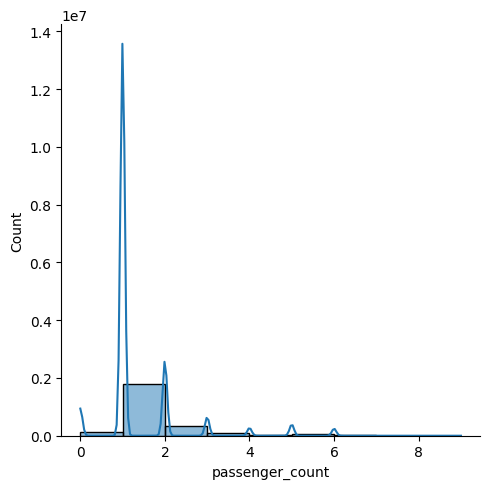

In [29]:
sns.displot(df_jan['passenger_count'], binwidth=1, kind="hist", kde=True)

As observed more than 70% of passengers travel only by themselves. And less than 10% of data is erraneous.

<Axes: >

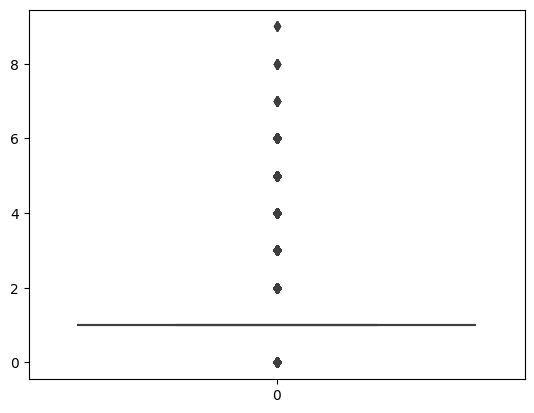

In [30]:
sns.boxplot(df_jan['passenger_count'])

It is considering data beyond 1 as outliers. But I will keep them as it is.

### trip_distance

In [31]:
df_jan['trip_distance'].sort_values()

487702          0.00
896412          0.00
449383          0.00
787720          0.00
309150          0.00
             ...    
2398837    193150.52
2419139    201283.16
2461083    250984.47
2429597    274658.81
2409416    306159.28
Name: trip_distance, Length: 2463931, dtype: float64

The domain seems pretty weird. There are values as 0 as well as values like 30k miles. According to TLC the maximum allowed trip duration in a 24 hour interval is 12 hours.

In [32]:
df = df_jan.copy()

In [33]:
def speed_distance_addition(df_month):
  zipped_ts = zip(df_month['tpep_dropoff_datetime'], df_month['tpep_pickup_datetime'])

  durations = []

  for (dropoff, pickup) in zipped_ts:
    durations.append(int((dropoff - pickup).total_seconds()))

  df_month['pickup_time'] = df_month['tpep_pickup_datetime'].apply(lambda x: x.timestamp())
  df_month['durations'] = durations
  df_month['speed'] = (df_month['trip_distance']/((df_month['durations'])/3600))

  df_month.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], inplace = True, axis=1)


In [34]:
speed_distance_addition(df)

We have two new features now -
1. Durations
2. Speed in (miles/hour)
3. Pickup Time (In UNIX format) - epoch from the beginnning.

In [35]:
df.head()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_time,durations,speed
0,1,2,3.80,1,N,142,236,1,14.5,3,0,3,0,0,21,2,0,1.640997e+09,1069,12.797007
1,1,1,2.10,1,N,236,42,1,8.0,0,0,4,0,0,13,0,0,1.640997e+09,504,15.000000
2,2,1,0.97,1,N,166,166,1,7.5,0,0,1,0,0,10,0,0,1.640998e+09,538,6.490706
3,2,1,1.09,1,N,114,68,2,8.0,0,0,0,0,0,11,2,0,1.640997e+09,602,6.518272
4,2,1,4.30,1,N,68,163,1,23.5,0,0,3,0,0,30,2,0,1.640997e+09,2252,6.873890


<Axes: >

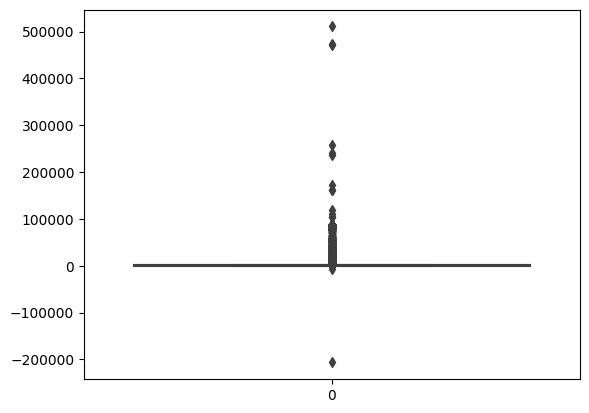

In [36]:
sns.boxplot(df['durations'])

Seems so many outliers here.

In [37]:
def percentile_checker(data, range):
  sorted_data = np.sort(data)
  length = len(data)
  ran = length/100;

  prev = 0

  for i in range:
    print(f"{i} percentile of the data is ", sorted_data[int(ran*i)], end = "")
    if(prev != 0):
      print(" Diff ", sorted_data[int(ran*i)] - prev)
    prev = sorted_data[int(ran*i)]


  print("100th percentile of the data is ", sorted_data[-1])
  print("Diff ", sorted_data[-1] - prev)


In [38]:
percentile_checker(df['durations'], range(10, 100, 10))

10 percentile of the data is  24120 percentile of the data is  336 Diff  95
30 percentile of the data is  422 Diff  86
40 percentile of the data is  512 Diff  90
50 percentile of the data is  611 Diff  99
60 percentile of the data is  727 Diff  116
70 percentile of the data is  876 Diff  149
80 percentile of the data is  1086 Diff  210
90 percentile of the data is  1478 Diff  392
100th percentile of the data is  510791
Diff  509313


Looking further from 90 percentile.

In [39]:
percentile_checker(df['durations'], range(90, 100, 1))

90 percentile of the data is  147891 percentile of the data is  1542 Diff  64
92 percentile of the data is  1615 Diff  73
93 percentile of the data is  1698 Diff  83
94 percentile of the data is  1798 Diff  100
95 percentile of the data is  1916 Diff  118
96 percentile of the data is  2062 Diff  146
97 percentile of the data is  2252 Diff  190
98 percentile of the data is  2529 Diff  277
99 percentile of the data is  3051 Diff  522
100th percentile of the data is  510791
Diff  507740


After 99% the data just rushes upwards.

In [40]:
print("No of points under 1 percentile", int(len(df['durations'])/100))

No of points under 1 percentile 24639


In [41]:
print("These points should be removed. As per guidelines as well only 12 hours worth of time is allowed.")

time_in_seconds = 12*60*60

These points should be removed. As per guidelines as well only 12 hours worth of time is allowed.


In [42]:
upd_df = df[(df['durations'] < time_in_seconds) & (df['durations']>0)]

In [43]:
print("Percentage of data saved", (len(upd_df)/len(df))*100, '%')

Percentage of data saved 99.7988985892868 %


<Axes: ylabel='durations'>

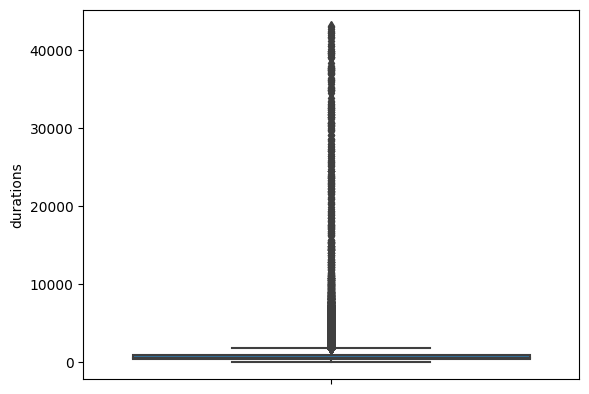

In [44]:
sns.boxplot(upd_df, y='durations')

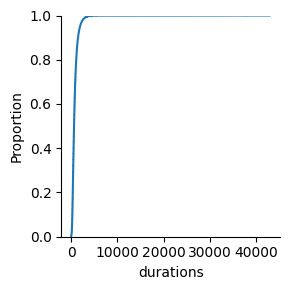

In [45]:
sns.FacetGrid(upd_df).map_dataframe(sns.ecdfplot, x="durations")

<Axes: xlabel='durations', ylabel='Density'>

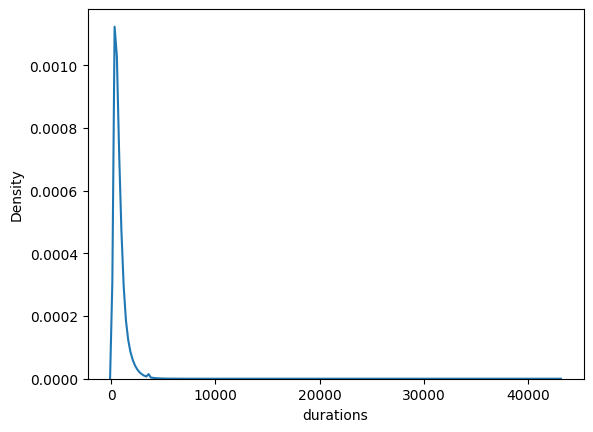

In [46]:
sns.kdeplot(upd_df, x = "durations")

Seems like log normal is it?

<Axes: ylabel='Density'>

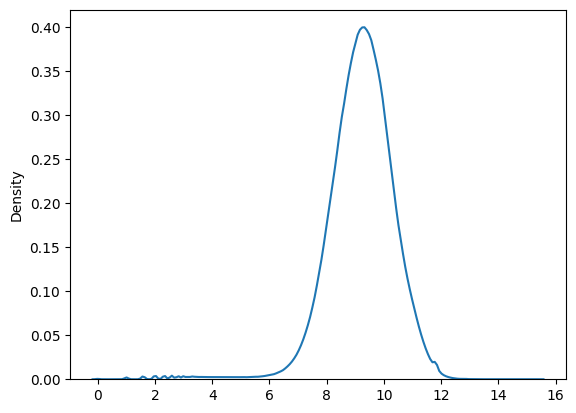

In [47]:
vals = [np.log2(x) for x in upd_df['durations']]
sns.kdeplot(vals)

<ipython-input-48-aad3ba64e863>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  upd_df['Log Normal Durations'] = vals


<Axes: ylabel='Density'>

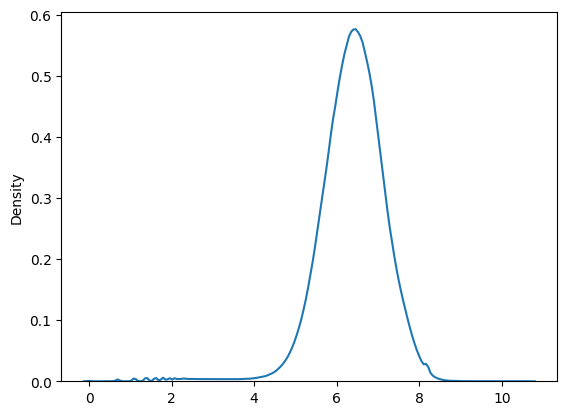

In [48]:
vals = [np.log(x) for x in upd_df['durations']]
upd_df['Log Normal Durations'] = vals
sns.kdeplot(vals)

In [49]:
normal_data = np.random.normal(0, 1, 100)

((array([-5.00323246, -4.82954475, -4.73581158, ...,  4.73581158,
          4.82954475,  5.00323246]),
  array([ 0.        ,  0.        ,  0.        , ..., 10.66279694,
         10.66990843, 10.67044266])),
 (0.7749192016839874, 6.37451601018924, 0.9636679971494789))

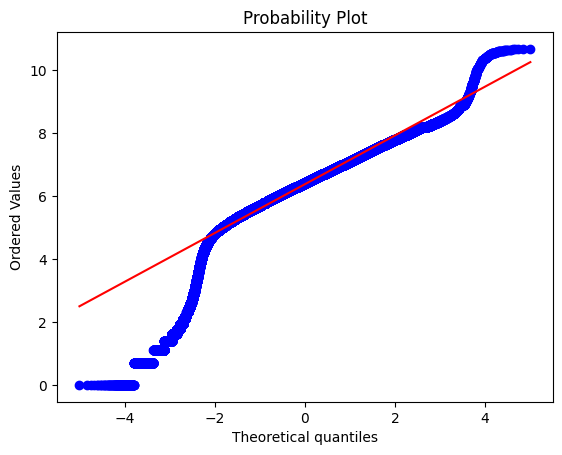

In [50]:
scipy.stats.probplot(vals, dist="norm", plot=plt)

### Speed and tpep_pickup_times

In [51]:
upd_df['speed'].sort_values()

703544           0.0
1084421          0.0
1084422          0.0
1948853          0.0
1508415          0.0
             ...    
2430394    2004482.2
2417144    2244395.4
2458062    2914845.6
2454079    6479684.4
2444205    7408456.2
Name: speed, Length: 2458976, dtype: float64

In [52]:
len(upd_df[upd_df['speed']==0])

28370

<Axes: ylabel='speed'>

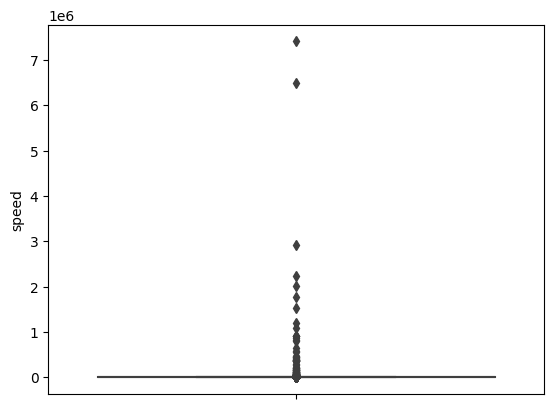

In [53]:
sns.boxplot(upd_df, y = "speed")

In [54]:
percentile_checker(upd_df['speed'], range(1, 100, 10))

1 percentile of the data is  0.011 percentile of the data is  7.00799999999999921 percentile of the data is  8.266666666666667 Diff  1.2586666666666684
31 percentile of the data is  9.24137931034483 Diff  0.9747126436781617
41 percentile of the data is  10.167531504818383 Diff  0.9261521944735538
51 percentile of the data is  11.148387096774194 Diff  0.9808555919558106
61 percentile of the data is  12.305847076461767 Diff  1.157459979687573
71 percentile of the data is  13.865429234338746 Diff  1.5595821578769797
81 percentile of the data is  16.399132321041215 Diff  2.5337030867024684
91 percentile of the data is  22.555282555282552 Diff  6.156150234241338
100th percentile of the data is  7408456.2
Diff  7408433.644717445


In [55]:
percentile_checker(upd_df['speed'], range(90, 100, 1))

90 percentile of the data is  21.5618374558303991 percentile of the data is  22.555282555282552 Diff  0.9934450994521633
92 percentile of the data is  23.661290322580644 Diff  1.1060077672980917
93 percentile of the data is  24.9041095890411 Diff  1.2428192664604545
94 percentile of the data is  26.333333333333336 Diff  1.429223744292237
95 percentile of the data is  27.994757536041938 Diff  1.6614242027086021
96 percentile of the data is  29.913175932977914 Diff  1.9184183969359765
97 percentile of the data is  32.19622641509434 Diff  2.2830504821164226
98 percentile of the data is  35.07692307692307 Diff  2.880696661828736
99 percentile of the data is  39.23378941106484 Diff  4.1568663341417675
100th percentile of the data is  7408456.2
Diff  7408416.966210589


In [56]:
speed_vals = np.sort(upd_df['speed'].values)
speed_vals = speed_vals[int(np.floor(0.99*len(speed_vals))):]
percentile_checker(speed_vals, range(1, 100, 10))

1 percentile of the data is  39.2843224092116911 percentile of the data is  39.88104089219331 Diff  0.5967184829816219
21 percentile of the data is  40.51525423728814 Diff  0.6342133450948282
31 percentile of the data is  41.23175416133163 Diff  0.7164999240434895
41 percentile of the data is  42.02733485193622 Diff  0.7955806906045879
51 percentile of the data is  43.0622009569378 Diff  1.0348661050015835
61 percentile of the data is  44.36239782016349 Diff  1.3001968632256862
71 percentile of the data is  46.285714285714285 Diff  1.9233164655507977
81 percentile of the data is  50.867192237719834 Diff  4.5814779520055495
91 percentile of the data is  362.57142857142856 Diff  311.7042363337087
100th percentile of the data is  7408456.2
Diff  7408093.628571428


In [57]:
prev_length = len(upd_df)
upd_df = upd_df[(upd_df['speed'] > 0) & (upd_df['speed']<50)]

In [58]:
print("Data Retained: ", (len(upd_df)/prev_length)*100)
print("Data Retained from initial dataset: ", (len(upd_df)/len(df_jan))*100)

Data Retained:  98.64732311336101
Data Retained from initial dataset:  98.44894195494922


We should also analyse the commute behaviour according to the time of day and the day itself. Sunday and Saturday might have some different behaviour and deserves to be a weight.

In [59]:
def convert_into_days_and_time_and_add_to_df(df):
  timestamps = df['pickup_time'].values;
  days = []
  day_time = []

  for ts in timestamps:
    dt_object = dt.datetime.fromtimestamp(ts)

    days.append(dt_object.strftime('%A'))

    hour = int(dt_object.strftime('%H'))

    if(hour>0 and hour <= 6):
      day_time.append("Midnight")
    elif(hour>6 and hour <= 12):
      day_time.append("Morning")
    elif(hour>12 and hour <= 18):
      day_time.append("Evening")
    else:
      day_time.append("Night")

  df['daytime'] = day_time
  df['days'] = days

In [60]:
convert_into_days_and_time_and_add_to_df(upd_df)

<ipython-input-59-06e2d2585768>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['daytime'] = day_time
<ipython-input-59-06e2d2585768>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['days'] = days


In [61]:
def plot_histogram_acc_daytime_days(df):
  dic = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
  morning = []
  evening = []
  midnight = []
  night = []
  for i in dic:
    morning.append(df[(df['days'] == i) & (df['daytime'] == 'Morning')].shape[0])
    evening.append(df[(df['days'] == i) & (df['daytime'] == 'Evening')].shape[0])
    midnight.append(df[(df['days'] == i) & (df['daytime'] == 'Midnight')].shape[0])
    night.append(df[(df['days'] == i) & (df['daytime'] == 'Night')].shape[0])

  days_df = pd.DataFrame({
      'morning': morning,
      'evening': evening,
      'midnight': midnight,
      'night': night
  })

  days_df.plot(kind='bar')
  days_df.plot(kind ='line')

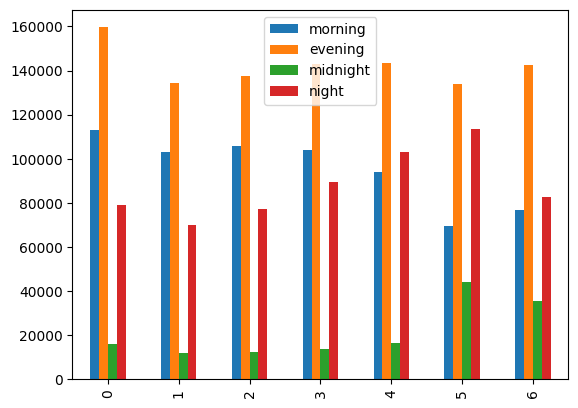

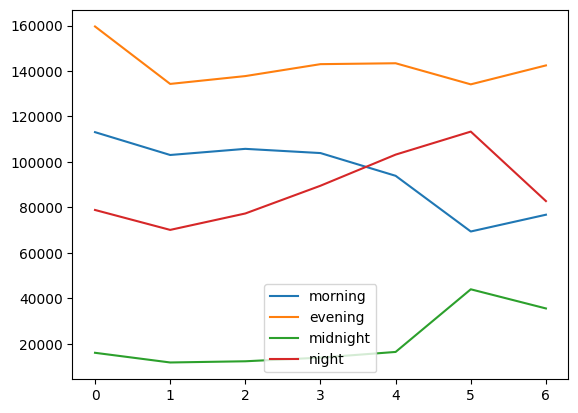

In [62]:
plot_histogram_acc_daytime_days(upd_df)

Inferences:
1. Monday remains the highest commute day. It seems obvious too
2. Tuesday is the day where it always drops. seems cool, but why?
3. As the days move forward to weekends, there is a sudden drop of morning commutes, and there is a sudden hike in night commutes. Most people moves out during weekends. Even midnight is pretty high those days.

These features tells a lot about the commute according to the day. So should be considered.

<Axes: ylabel='trip_distance'>

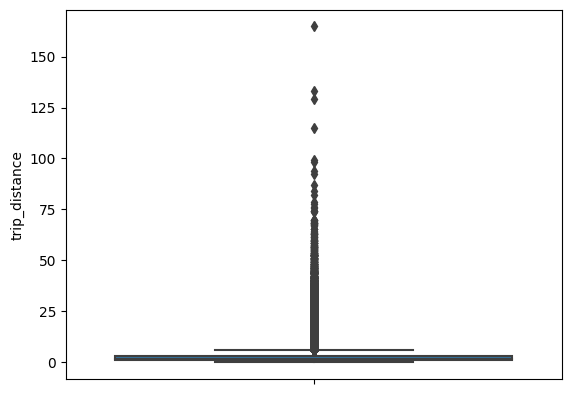

In [63]:
sns.boxplot(upd_df,y = 'trip_distance')

In [64]:
percentile_checker(upd_df['trip_distance'], range(10, 100, 10))

10 percentile of the data is  0.720 percentile of the data is  0.94 Diff  0.24
30 percentile of the data is  1.2 Diff  0.26
40 percentile of the data is  1.45 Diff  0.25
50 percentile of the data is  1.77 Diff  0.32000000000000006
60 percentile of the data is  2.16 Diff  0.3900000000000001
70 percentile of the data is  2.72 Diff  0.56
80 percentile of the data is  3.76 Diff  1.0399999999999996
90 percentile of the data is  7.2 Diff  3.4400000000000004
100th percentile of the data is  164.81
Diff  157.61


In [65]:
percentile_checker(upd_df['trip_distance'], range(90, 100, 1))

90 percentile of the data is  7.291 percentile of the data is  7.98 Diff  0.7800000000000002
92 percentile of the data is  8.8 Diff  0.8200000000000003
93 percentile of the data is  9.58 Diff  0.7799999999999994
94 percentile of the data is  10.5 Diff  0.9199999999999999
95 percentile of the data is  11.78 Diff  1.2799999999999994
96 percentile of the data is  14.4 Diff  2.620000000000001
97 percentile of the data is  17.12 Diff  2.7200000000000006
98 percentile of the data is  18.23 Diff  1.1099999999999994
99 percentile of the data is  19.6 Diff  1.370000000000001
100th percentile of the data is  164.81
Diff  145.21


In [66]:
percentile_checker(upd_df['trip_distance'][int(len(upd_df['trip_distance'].sort_values())*0.99):], range(90, 100, 1))

90 percentile of the data is  7.7591 percentile of the data is  8.21 Diff  0.46000000000000085
92 percentile of the data is  8.72 Diff  0.5099999999999998
93 percentile of the data is  9.31 Diff  0.5899999999999999
94 percentile of the data is  10.1 Diff  0.7899999999999991
95 percentile of the data is  10.84 Diff  0.7400000000000002
96 percentile of the data is  11.97 Diff  1.1300000000000008
97 percentile of the data is  13.78 Diff  1.8099999999999987
98 percentile of the data is  16.58 Diff  2.799999999999999
99 percentile of the data is  18.6 Diff  2.020000000000003
100th percentile of the data is  46.3
Diff  27.699999999999996


On average speed, the TLC taxis can go upto 80 miles during the whole commute.

In [67]:
prev_length = len(upd_df)
upd_df = upd_df[upd_df['trip_distance'] < 80]

print(prev_length)
print(len(upd_df))

print("Data Retained: ", ((prev_length / len(upd_df))*100), "%")

2425714
2425703
Data Retained:  100.0004534767859 %


<Axes: xlabel='trip_distance', ylabel='Density'>

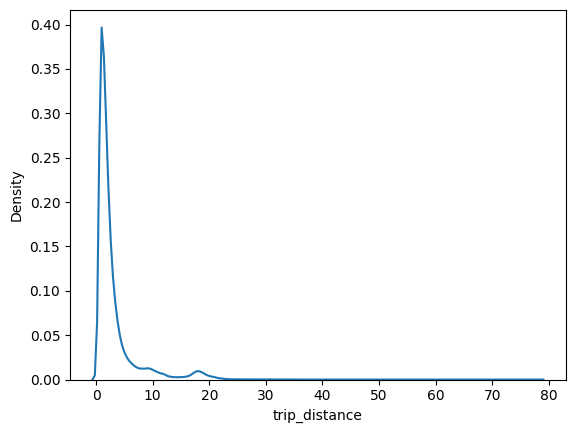

In [68]:
sns.kdeplot(upd_df['trip_distance'])

Again it seems like log normal. Converting it to normal form.

<Axes: ylabel='Density'>

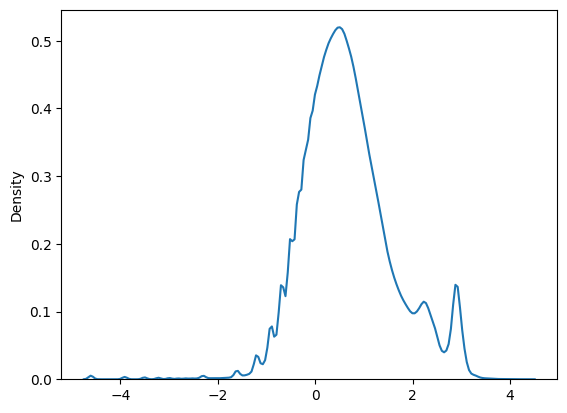

In [69]:
vals = [np.log(x) for x in upd_df['trip_distance']]
sns.kdeplot(vals)

((array([-5.00060666, -4.82683113, -4.73304818, ...,  4.73304818,
          4.82683113,  5.00060666]),
  array([-4.60517019, -4.60517019, -4.60517019, ...,  4.33204826,
          4.35027794,  4.36195147])),
 (0.9074785267965834, 0.6669041044272473, 0.9842687373940988))

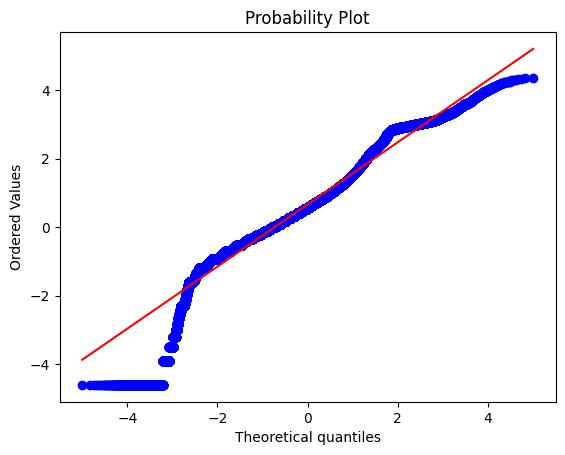

In [70]:
scipy.stats.probplot(vals, dist="norm", plot = plt)

Seems good to add

In [71]:
upd_df['Log Normal TripDistances'] = vals

<Axes: >

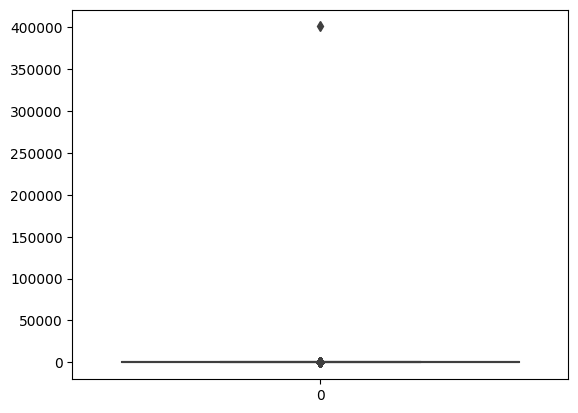

In [72]:
sns.boxplot(upd_df['total_amount'])

In [73]:
percentile_checker(upd_df['total_amount'], range(90, 100, 1))

90 percentile of the data is  3291 percentile of the data is  35 Diff  3
92 percentile of the data is  38 Diff  3
93 percentile of the data is  42 Diff  4
94 percentile of the data is  45 Diff  3
95 percentile of the data is  50 Diff  5
96 percentile of the data is  56 Diff  6
97 percentile of the data is  63 Diff  7
98 percentile of the data is  70 Diff  7
99 percentile of the data is  75 Diff  5
100th percentile of the data is  401095
Diff  401020


In [74]:
vals = np.sort(upd_df['total_amount'])
vals = vals[int(len(vals)*0.999):]

percentile_checker(vals, range(90, 100, 1))

90 percentile of the data is  20091 percentile of the data is  204 Diff  4
92 percentile of the data is  209 Diff  5
93 percentile of the data is  218 Diff  9
94 percentile of the data is  224 Diff  6
95 percentile of the data is  233 Diff  9
96 percentile of the data is  242 Diff  9
97 percentile of the data is  258 Diff  16
98 percentile of the data is  280 Diff  22
99 percentile of the data is  306 Diff  26
100th percentile of the data is  401095
Diff  400789


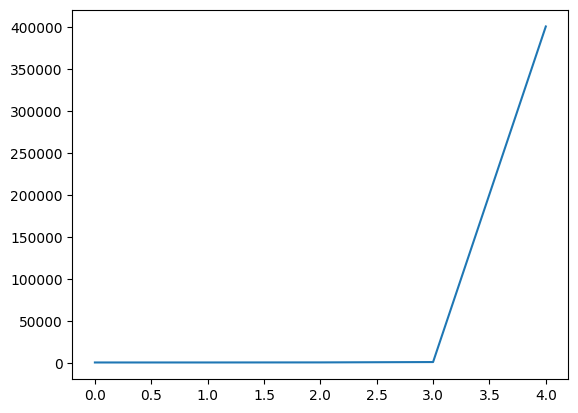

In [75]:
plt.plot(np.sort(upd_df['total_amount'])[-5:])

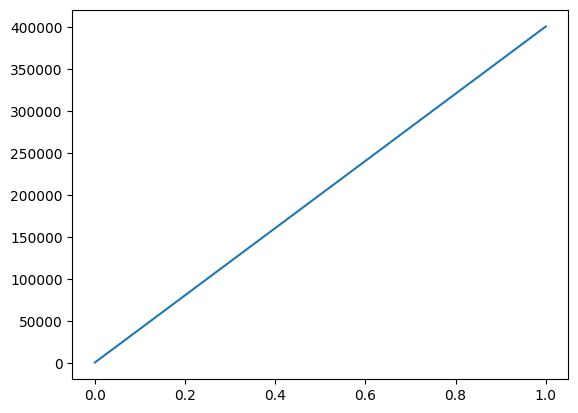

In [76]:
plt.plot(np.sort(upd_df['total_amount'])[-2:])

It is just one value which is an outlier.

In [77]:
upd_df = upd_df[upd_df['total_amount'] < 1000]

### pickup and dropoff points

In [78]:
upd_df.head()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,...,total_amount,congestion_surcharge,airport_fee,pickup_time,durations,speed,Log Normal Durations,daytime,days,Log Normal TripDistances
0,1,2,3.80,1,N,142,236,1,14.5,3,...,21,2,0,1.640997e+09,1069,12.797007,6.974479,Night,Saturday,1.335001
1,1,1,2.10,1,N,236,42,1,8.0,0,...,13,0,0,1.640997e+09,504,15.000000,6.222576,Night,Saturday,0.741937
2,2,1,0.97,1,N,166,166,1,7.5,0,...,10,0,0,1.640998e+09,538,6.490706,6.287859,Night,Saturday,-0.030459
3,2,1,1.09,1,N,114,68,2,8.0,0,...,11,2,0,1.640997e+09,602,6.518272,6.400257,Night,Saturday,0.086178
4,2,1,4.30,1,N,68,163,1,23.5,0,...,30,2,0,1.640997e+09,2252,6.873890,7.719574,Night,Saturday,1.458615


We need PULocationID to be converted to latitude and longitude. Also I am not considering the DropLocationID so that column is getting dropped (because we did same to the dropoff_time as we dont want that)

In [79]:
lookup_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test_tripdata/taxi_id.csv')

In [80]:
lookup_df.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


Text(0, 0.5, 'Number of unique values')

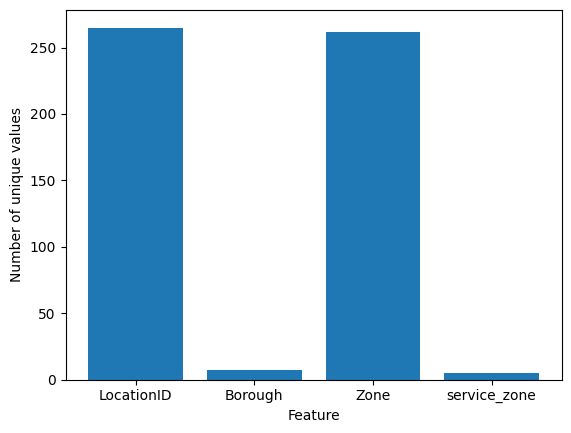

In [81]:
values = []

for i in list(lookup_df.columns):
  values.append(len(lookup_df[i].unique()))

plt.bar(list(lookup_df.columns), values)
plt.xlabel("Feature")
plt.ylabel("Number of unique values")

Zone seems appropriate fit. Is service_zone or borough a good idea for featurization?

1. These are only six zones, but give a good overview of the area type. It can be the airport, yellow zone, borrow zone.
2. Adding borough will make more sense, as it have more unique values
3. Borough and service_zone will be kind of collinear.
4. But then, it will be more better to just add zone to the features, because zone will kind of map to a particular state/zone and will be highly divisional as compared to borough. Different zones might have different airports as well, borough will not cover them well, but service_zone will.
5. Lets add both service_zone and zone to the dataset. They might give a proper stat on a bigger as well as closer area.

But currently I only have locationIDs to Zone with me, which does not translate to latitude and longitude.

In [82]:
taxi_ids = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test_tripdata/taxi_zones.csv')

In [83]:
taxi_ids.head()

,OBJECTID,Shape_Leng,the_geom,Shape_Area,zone,LocationID,borough
0,1,0.116357,MULTIPOLYGON (((-74.18445299999996 40.69499599...,0.000782,Newark Airport,1,EWR
1,2,0.433470,MULTIPOLYGON (((-73.82337597260663 40.63898704...,0.004866,Jamaica Bay,2,Queens
2,3,0.084341,MULTIPOLYGON (((-73.84792614099985 40.87134223...,0.000314,Allerton/Pelham Gardens,3,Bronx
3,4,0.043567,MULTIPOLYGON (((-73.97177410965318 40.72582128...,0.000112,Alphabet City,4,Manhattan
4,5,0.092146,MULTIPOLYGON (((-74.17421738099989 40.56256808...,0.000498,Arden Heights,5,Staten Island


Instead of putting zone, let's put shape area which is a floating point number. Shape_Area is a number so it might be easy because zone name then will be needed to coded in numerical forms first while modelling. Also while querying, the shape area point will might give an inference to area around a particular latlon than the zone only.



In [84]:
taxi_ids['the_geom'] = taxi_ids['the_geom'].apply(lambda x: pg.loads(x))

In [85]:
taxi_ids['latitude'] = taxi_ids['the_geom'].apply(lambda v: v.centroid.x)
taxi_ids['longitude'] = taxi_ids['the_geom'].apply(lambda v: v.centroid.y)

In [86]:
taxi_ids = taxi_ids.drop(['Shape_Leng', 'borough', 'OBJECTID'], axis = 1)

In [87]:
taxi_ids.head()

len(taxi_ids['LocationID'].unique())
len(taxi_ids)

263

There are some duplicate Location IDs

In [88]:
location_ids = taxi_ids['LocationID'].unique()

missing_ids = []

for ids in upd_df['PULocationID'].unique():
  if(ids not in location_ids):
    missing_ids.append(ids)
    print(ids, "not in location_ids")

265 not in location_ids
264 not in location_ids
57 not in location_ids
105 not in location_ids


Unfortunately, I have to remove these from the data, because I cannot find the data related to these particular location IDs

In [89]:
prev_length = len(upd_df)
upd_df = upd_df[(upd_df['PULocationID'] != 265) & (upd_df['PULocationID'] != 264) & (upd_df['PULocationID'] != 57) & (upd_df['PULocationID'] != 105)]

print("Data retained: ", (len(upd_df)/prev_length)*100)

Data retained:  98.99773343963932


In [90]:
lat_mapper = pd.Series(taxi_ids['latitude'].values, index = taxi_ids['LocationID'].values).to_dict()
long_mapper = pd.Series(taxi_ids['longitude'].values, index = taxi_ids['LocationID'].values).to_dict()

upd_df['latitude'] = upd_df['PULocationID'].apply(lambda id: lat_mapper[id])
upd_df['longitude'] = upd_df['PULocationID'].apply(lambda id: long_mapper[id])

As the data is from NYC Taxis only (PULocationID) -> latitude and longitude might not have outliers. So it is just fine to continue.

# Removing outliers and updating the data

In [91]:
def remove_outliers_and_add_features(frame, month, year):
  preprocess(frame)
  leng = len(frame)
  print("Length of Original Data: ", len(frame))

  frame = frame.drop(['airport_fee', 'VendorID', 'congestion_surcharge', 'improvement_surcharge', 'tolls_amount', 'tip_amount', 'mta_tax', 'extra', 'fare_amount', 'payment_type', 'store_and_fwd_flag', 'RatecodeID', 'DOLocationID'], axis=1)

  print("Removing Dropoff Time Outliers")
  frame = frame[(frame['tpep_dropoff_datetime'].dt.year==year) & (frame['tpep_dropoff_datetime'].dt.month==month)]
  print("Percentage Remaining: ", (len(frame)/leng)*100)

  print("Removing tpep_pickup_datetime Outliers")
  frame = frame[(frame['tpep_pickup_datetime'].dt.year==year) & (frame['tpep_pickup_datetime'].dt.month==month)]
  print("Percentage Remaining: ", (len(frame)/leng)*100)

  print("Adding Speed Distance Features")
  speed_distance_addition(frame)
  time_in_seconds = 12*60*60
  frame = frame[(frame['durations'] < time_in_seconds) & (frame['durations']>0)]
  print("Percentage Remaining: ", (len(frame)/leng)*100)

  print("Adding Log Normal Durations")
  frame['ln-durations'] = [np.log(x) for x in frame['durations']]

  print("Removing Speed Outliers")
  frame = frame[(frame['speed'] > 0) & (frame['speed']<50)]
  print("Percentage Remaining: ", (len(frame)/leng)*100)

  convert_into_days_and_time_and_add_to_df(frame)
  frame = frame[frame['trip_distance'] < 80]
  print("Percentage Remaining: ", (len(frame)/leng)*100)

  print("Adding log-normal-trip-distances")
  frame['ln-tripdistances'] = [np.log(x) for x in frame['trip_distance']]

  print("Removing total_amount Outliers")
  frame = frame[frame['total_amount'] < 1000]
  print("Percentage Remaining: ", (len(frame)/leng)*100)

  print("Removal of invalid PULocationIDs")
  frame = frame[(frame['PULocationID'] != 265) & (frame['PULocationID'] != 264) & (frame['PULocationID'] != 57) & (frame['PULocationID'] != 105)]
  print("Percentage Remaining: ", (len(frame)/leng)*100)

  print("Adding latitudes and longitudes")
  frame['latitude'] = frame['PULocationID'].apply(lambda id: lat_mapper[id])
  frame['longitude'] = frame['PULocationID'].apply(lambda id: long_mapper[id])

  return frame

I am thinking to create clusters based on the PULocationID, I feel its fine to have it like this, because the locations are already clustered in a really good way.

In [105]:
def get_10_minutes_bin(frame, ts):
  jan_start_2022 = ts
  ts = frame['pickup_time'].values
  bins = []
  for i in ts:
    bins.append(int((i - jan_start_2022)/600)+1)
  frame['time_bins'] = bins

  return frame

In [93]:
upd_df = upd_df[(upd_df['pickup_time']>=1640995200) & (upd_df['pickup_time']<1643673600)]

# Just a mistake, this will be rectified if the remove_outliers_and_add_features function is used by any other month dataframe.

In [94]:
no_of_bins = int(24*31*60/10)

In [95]:
upd_df = get_10_minutes_bin(upd_df, 1640995200)

In [96]:
np.max(upd_df['time_bins'])

4464

In [97]:
def binary_search(arr, x):
  start = 0
  end = len(arr)

  while(end - start > 1):
    mid = start + int((end-start)/2);

    if(arr[mid] < x):
      start = mid
    else:
      end = mid

  return (start, end)

In [98]:
# smoothed_data = []

# noclusters = []

# for i in range(1, 264):
#   if i not in upd_df['PULocationID'].values:
#     noclusters.append(i)

# for i in tqdm(range(1, 264)):
#   if i in noclusters:
#     continue;

#   grp = upd_df.groupby('PULocationID').get_group(i)
#   smoothed_data_pc = []
#   pres_values = sorted(grp['time_bins'].values)

#   # time_bins
#   for j in range(1, no_of_bins+1):
#     if(len(grp[grp['time_bins'] == j])>0):
#       smoothed_data_pc.append(len(grp[grp['time_bins'] == j]))
#     else:
#       if(j<pres_values[0]):
#         smoothed_data_pc.append(int(np.ceil(len(grp[grp['time_bins'] == pres_values[0]])/(pres_values[0]))))
#       else:
#         (before, after) = binary_search(np.array(pres_values), j)
#         if(after == len(pres_values)):
#           smoothed_data_pc.append(int(np.ceil(len(grp[grp['time_bins'] == pres_values[-1]])/no_of_bins - pres_values[-1])))
#         else:
#           smoothed_data_pc.append(int(np.ceil((len(grp[grp['time_bins'] == pres_values[after]]) + len(grp[grp['time_bins'] == pres_values[before]]))/(after-before+1))))

#   smoothed_data.append(smoothed_data_pc)


The above computation is really slow to compute. Optimized approach below:

In [99]:
noclusters = []

for i in range(1, 264):
  if i not in upd_df['PULocationID'].values:
    noclusters.append(i)

def get_nulls(grp):
  smoothed_data = []

  for j in range(1, no_of_bins+1):
    if(len(grp[grp['time_bins'] == j])>0):
      smoothed_data.append(len(grp[grp['time_bins'] == j]))
    else:
      smoothed_data.append(0)

  return smoothed_data

smoothened_bins = []

for i in tqdm(range(1, 264)):
  if i in noclusters:
    # append something here
    smoothened_bins.append([])
    continue;

  grp = upd_df.groupby('PULocationID').get_group(i)
  null_vec = get_nulls(grp)

  indi = 0

  while(null_vec[indi] == 0):
    indi += 1

  if(indi != 0):
    val = int(np.ceil(null_vec[indi]/indi))

    for k in range(0, indi):
      null_vec[k] = val

  first = indi

  for t in range(indi+1, len(null_vec)):
    while(null_vec[t] == 0):
      t += 1
      if(t >= len(null_vec)):
        break;

    if(t >= len(null_vec)):
        break;

    if(t-first <=1):
      continue

    val = int(np.ceil((null_vec[first] + null_vec[t])/(t - first + 1)))

    for k in range(first+1, t):
      null_vec[k] = val

    first = t

  if(first<len(null_vec)-1):
    val = int(np.ceil((null_vec[first])/(len(null_vec) - first)))
    for k in range(first+1, len(null_vec)):
      null_vec[k] = val

  smoothened_bins.append(null_vec)

100%|██████████| 263/263 [10:45<00:00,  2.46s/it]


Now we actually have smoothened_bins. It is 264*4464 data, containing all the count of the trips happening at particular 10 minute bin.

## Time Series and Fourier Data

Printing Top 15 Areas time series

In [100]:
dictn = {}

for i in range(1, 264):
  if(len(smoothened_bins) > 0):
    dictn[f"{i}"] = sum(smoothened_bins[i-1])

sorted_by_tops = sorted(dictn.items(), key=lambda x:x[1], reverse=True)
print(sorted_by_tops)

[('237', 101877), ('236', 101022), ('132', 84020), ('161', 74101), ('186', 67455), ('142', 67454), ('141', 65211), ('48', 64344), ('239', 63750), ('170', 63061), ('162', 62704), ('230', 57571), ('234', 54397), ('163', 54310), ('79', 54015), ('263', 52858), ('140', 52614), ('238', 51026), ('138', 50612), ('107', 50538), ('68', 49905), ('229', 46873), ('249', 46537), ('164', 40682), ('90', 37194), ('43', 35459), ('262', 33413), ('100', 33396), ('137', 31596), ('143', 29413), ('113', 27758), ('246', 26534), ('233', 26531), ('114', 25969), ('231', 24429), ('151', 22769), ('75', 19321), ('148', 19268), ('144', 17379), ('50', 15876), ('158', 15318), ('211', 14993), ('166', 12320), ('125', 10625), ('13', 10341), ('87', 9969), ('70', 9908), ('261', 9472), ('24', 9098), ('41', 9004), ('74', 8419), ('88', 6711), ('224', 5864), ('209', 5466), ('4', 5335), ('232', 5273), ('42', 5268), ('45', 5197), ('116', 5097), ('244', 4957), ('152', 4952), ('226', 4934), ('7', 4751), ('146', 4679), ('65', 4619)

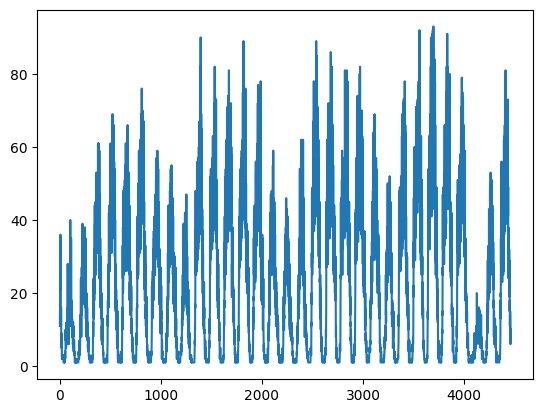

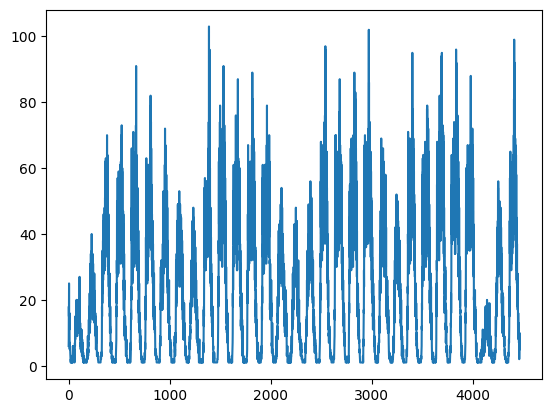

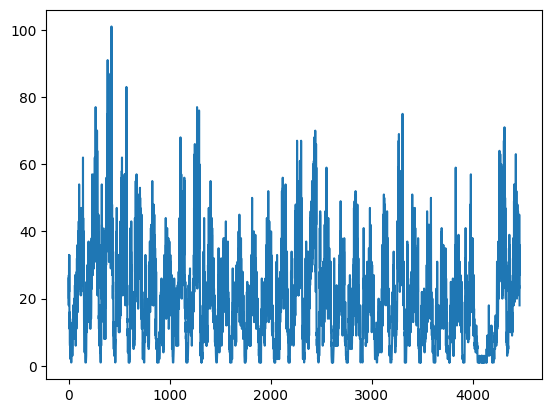

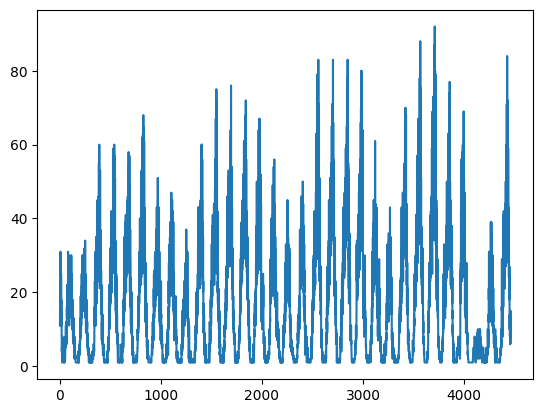

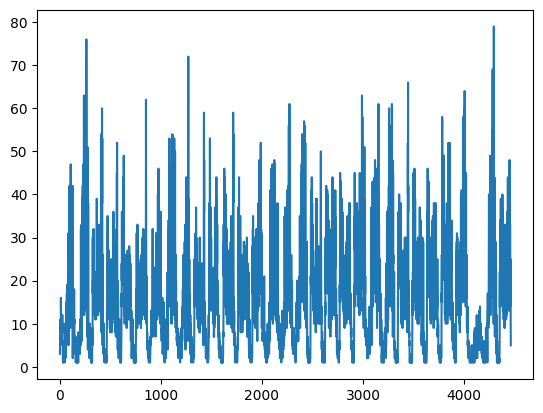

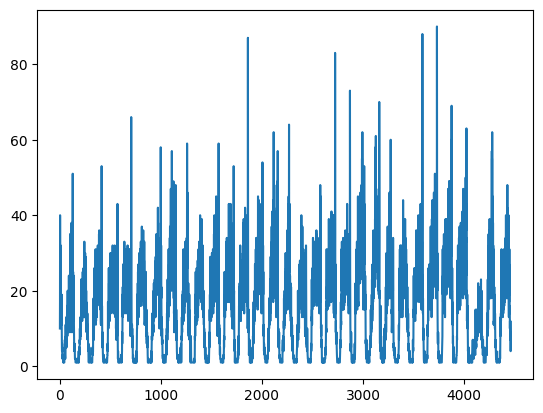

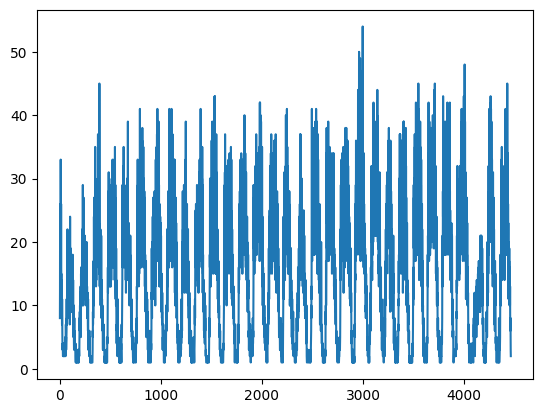

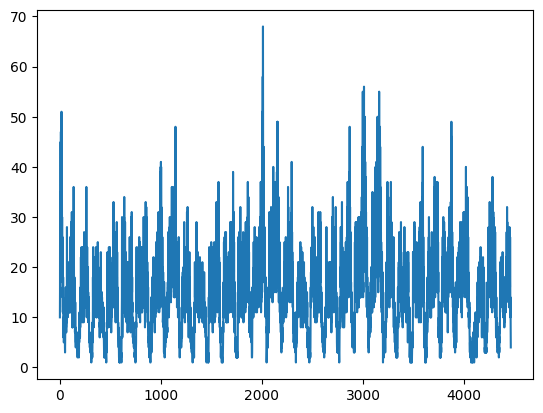

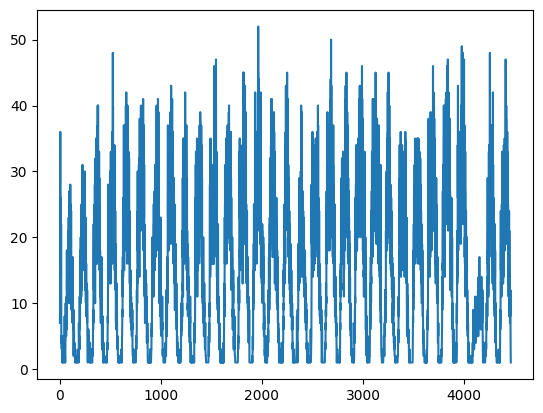

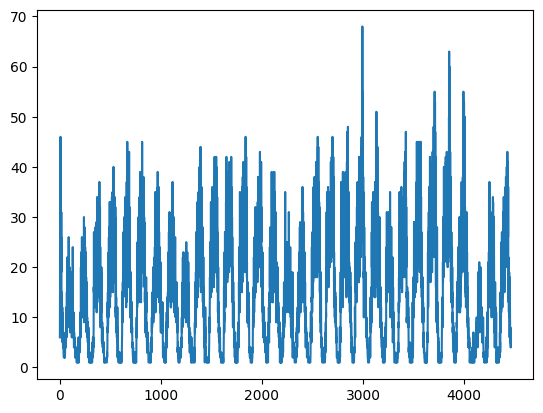

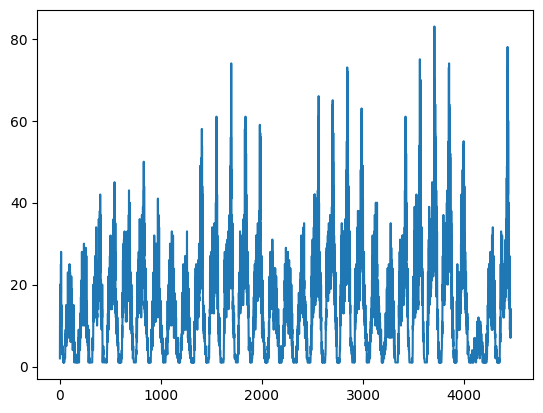

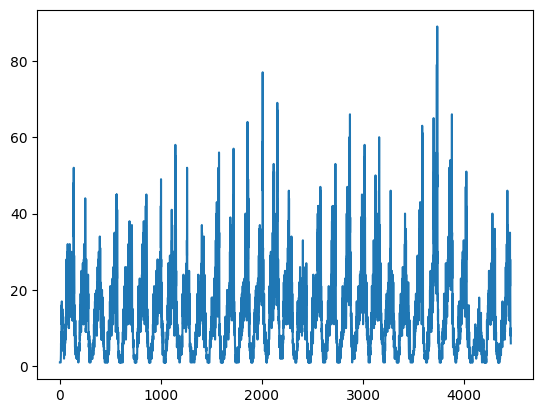

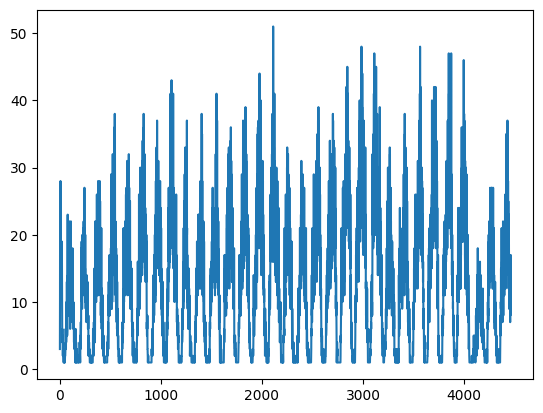

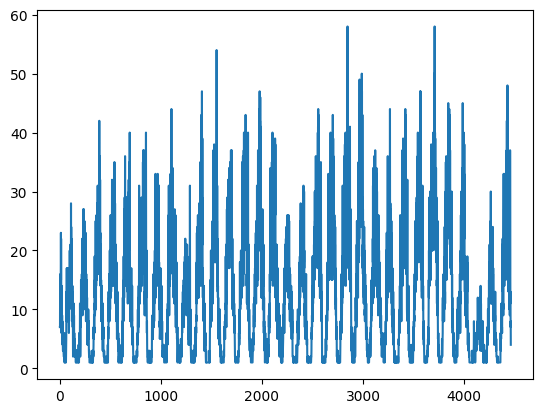

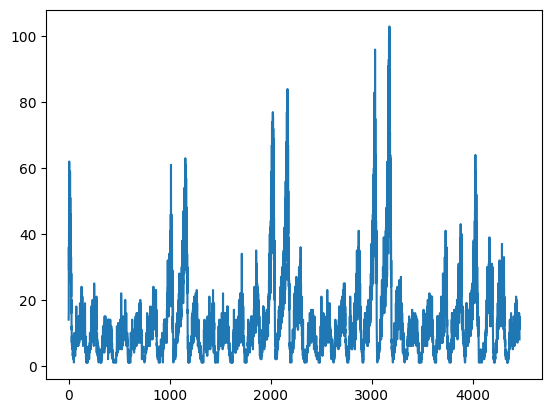

In [101]:
for i in range(0, 15):
  plt.plot(range(0, no_of_bins),smoothened_bins[int(sorted_by_tops[i][0]) - 1])
  plt.show()

Performing Fourier Transformation

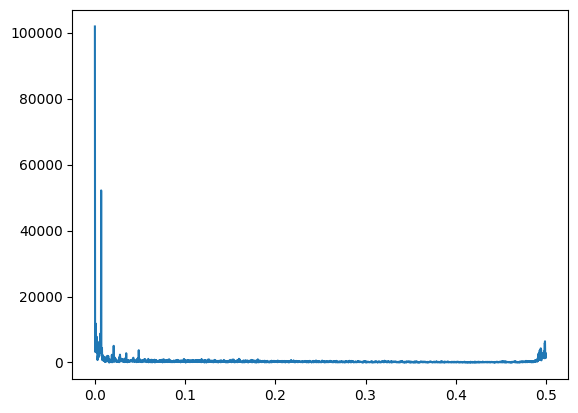

In [102]:
'''
ft = np.fft.fft(smoothened_bins[236]):
This line computes the Fast Fourier Transform (FFT) of the data located at index 236 in the smoothened_bins array. The FFT is a mathematical algorithm used to transform a signal from its original domain (usually time or space) into the frequency domain.
freq = np.fft.fftfreq(4464):
This line generates an array of frequencies corresponding to the FFT result obtained earlier. The fftfreq function from NumPy generates the frequency values for the given FFT result. Here, it seems the FFT result was obtained from a signal of length 4464.
n = len(freq):
This line calculates the length of the frequency array generated, which will be used for plotting.
plt.plot(freq[:int(n/2)], np.abs(ft)[:int(n/2)]):
This line creates a plot of the FFT result against the frequency values.
freq[:int(n/2)] selects the first half of the frequency array. Since the FFT result is symmetric due to the nature of real-valued input, only the first half is usually considered as the other half is a mirror image.
np.abs(ft)[:int(n/2)] takes the absolute values of the FFT result and selects the first half of it.
plt.plot() is a function from the Matplotlib library used to create the plot.
'''

ft = np.fft.fft(smoothened_bins[236])
freq = np.fft.fftfreq(4464)

n = len(freq)

plt.plot(freq[:int(n/2)], np.abs(ft)[:int(n/2)])

Not much experienced with Fourier myself, just tried as heard somewhere that it is good for feature transformations for a timeseries data. The waves look really good to me too, they repeat in a pattern (like a sin wave) but, let's skip this feature for now.

## Modelling

Building a Baseline Model is required first. As it is a time series dataset, just previous some values can be used to derive the future result. Let's create such a baseline model.

Creating three models -

1. Simple Moving Averages
2. Weighted Moving Averages
3. Exponential Moving Averages

In [106]:
jan_2023_df = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/test_tripdata/yellow_tripdata_2023-01.parquet')
jan_2023_df = remove_outliers_and_add_features(jan_2023_df, 1, 2023)

jan_2023_smoothened = []
noclusters = []

for i in range(1, 264):
  if i not in jan_2023_df['PULocationID'].values:
    noclusters.append(i)

extra preprocessing
mta_tax preprocessing
tip_amount preprocessing
tolls_amount preprocessing
improvement_surcharge preprocessing
total_amount preprocessing
congestion_surcharge preprocessing
airport_fee preprocessing
Length of Original Data:  3066766
Removing Dropoff Time Outliers
Percentage Remaining:  99.97906589547425
Removing tpep_pickup_datetime Outliers
Percentage Remaining:  99.97864199616143
Adding Speed Distance Features
Percentage Remaining:  99.86014583440667
Adding Log Normal Durations
Removing Speed Outliers
Percentage Remaining:  98.30362016534681
Percentage Remaining:  98.30283758200005
Adding log-normal-trip-distances
Removing total_amount Outliers
Percentage Remaining:  98.30283758200005
Removal of invalid PULocationIDs
Percentage Remaining:  97.03978066797401
Adding latitudes and longitudes


In [110]:
for i in tqdm(range(1, 264)):
  if i in noclusters:
    jan_2023_smoothened.append([])
    continue;

  grp = jan_2023_df.groupby('PULocationID').get_group(i)
  grp = get_10_minutes_bin(grp, 1672531200)
  grp.head()
  jan_2023_smoothened.append(get_nulls(grp))

  0%|          | 0/263 [00:00<?, ?it/s]<ipython-input-105-5f908b186924>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['time_bins'] = bins
  0%|          | 1/263 [00:01<08:35,  1.97s/it]<ipython-input-105-5f908b186924>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['time_bins'] = bins
  1%|          | 2/263 [00:03<08:07,  1.87s/it]<ipython-input-105-5f908b186924>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [111]:
np.save('smoothened_bins_2022-Jan.npy', smoothened_bins)
np.save('smoothened_bins_2023-Jan.npy', jan_2023_smoothened)

!cp smoothened_bins_2022-Jan.npy /content/drive/MyDrive/Colab\ Notebooks/test_tripdata
!cp smoothened_bins_2023-Jan.npy /content/drive/MyDrive/Colab\ Notebooks/test_tripdata

/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Little repair of the data, I know this is not the correct approach, but let's do it for now.

In [145]:
for i in range(1, 264):
  if i not in upd_df['PULocationID'].values:
    smoothened_bins[i-1] = [1]*no_of_bins

In [146]:
jan_2023_smoothened = np.load('/content/drive/MyDrive/Colab Notebooks/test_tripdata/smoothened_bins_2023-Jan.npy', allow_pickle=True)
for i, val in enumerate(jan_2023_smoothened):
  if(len(val) == 0):
    jan_2023_smoothened[i] = [0]*no_of_bins

In [149]:
model_data = pd.DataFrame()
model_data['to_predict'] = jan_2023_smoothened
model_data['x'] = smoothened_bins
ratio_bins = [ [0]*(no_of_bins) for i in range(1, 264)]


for i in range(0, len(jan_2023_smoothened)):
  for j in range(0, len(jan_2023_smoothened[i])):
    ratio_bins[i][j] = jan_2023_smoothened[i][j] / smoothened_bins[i][j]

In [150]:
model_data['ratios'] = ratio_bins
model_data.head()

,to_predict,x,ratios
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[0, 2, 5, 5, 4, 3, 3, 2, 6, 2, 8, 7, 10, 6, 9,...","[1, 1, 1, 2, 2, 3, 2, 3, 2, 2, 2, 3, 3, 6, 4, ...","[0.0, 2.0, 5.0, 2.5, 2.0, 1.0, 1.5, 0.66666666..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Simple Moving Average Model

As it is a continuous up-down curve its fine to use last 3 values to predict the future values. Also the below stuff can be done on both, ratios and values. Ratios give me little offset on the past values, so using that.

In [187]:
def MAR_Predictions():
    predicted_ratio = np.array(model_data['ratios'].values.tolist()).flatten()
    to_predict = np.array(model_data['to_predict'].values.tolist()).flatten()
    x = np.array(model_data['x'].values.tolist()).flatten()

    error=[]
    predicted_values = []
    predicted_ratios = []

    # for first three value just doing it 0 for now, 3 timeblocks from first will receive just the same value as output. This isnt good, but yep when this will be streamlined as the time, it will make sense.
    predicted_ratios.extend([0,0,0])
    predicted_values.extend([x[0], x[1], x[2]])
    error.extend([np.abs(to_predict[i] - x[i]) for i in range(0, 3)])

    for i in tqdm(range(3, len(predicted_ratio))):
        pr = np.sum(predicted_ratio[i-3:i])/3
        predicted_ratios.append(pr)
        predicted_values.append(x[i]*pr)
        error.append(np.abs(predicted_values[i]-to_predict[i]))

    mse_error = np.sum([i*i for i in error])

    return mse_error/len(error)

In [188]:
mse_error_simple = MAR_Predictions()

100%|██████████| 1174029/1174029 [00:12<00:00, 97818.75it/s] 


In [194]:
def WA_Predictions():
    predicted_ratio = np.array(model_data['ratios'].values.tolist()).flatten()
    to_predict = np.array(model_data['to_predict'].values.tolist()).flatten()
    x = np.array(model_data['x'].values.tolist()).flatten()

    error=[]
    predicted_values = []

    # for first three value just doing it 0 for now, 3 timeblocks from first will receive just the same value as output. This isnt good, but yep when this will be streamlined as the time, it will make sense.
    predicted_values.extend([x[0], x[1], x[2]])
    error.extend([np.abs(to_predict[i] - x[i]) for i in range(0, 3)])

    for i in tqdm(range(3, len(predicted_ratio))):
        pr = (predicted_ratio[i-3]*1 + predicted_ratio[i-2]*2 + predicted_ratio[i-1]*3)/6
        predicted_values.append(x[i]*pr)
        error.append(np.abs(predicted_values[i]-to_predict[i]))

    mse_error = np.sum([i*i for i in error])

    return mse_error/len(error)

In [195]:
mse_error_weighted = WA_Predictions()

100%|██████████| 1174029/1174029 [00:04<00:00, 284110.75it/s]


In [196]:
print(mse_error_weighted)

16.145412875896866
